<a href="https://colab.research.google.com/github/jimin0/2023_JUMP_AI/blob/main/%EC%8B%A0%EC%95%BD%EA%B0%9C%EB%B0%9C_preprocessing_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

from torch.optim import AdamW
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# data upload
train_df = pd.read_csv('/content/drive/MyDrive/2023_신약개발대회/open/train.csv', encoding='UTF-8')
test_df = pd.read_csv('/content/drive/MyDrive/2023_신약개발대회/open/test.csv', encoding='UTF-8')

In [ ]:
# Display the first few rows of the DataFrame to understand its structure
train_df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [ ]:
test_df.columns

# target 값 column에 추가
test_df['MLM'] = 0
test_df['HLM'] = 0

test_df

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,MLM,HLM
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76,0,0
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31,0,0
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86,0,0
3,TEST_003,O=C(c1nc2ncccn2n1)N1CCCn2cc(-c3ccccc3)nc21,1.795,345.358,5,0,2,1.795,81.21,0,0
4,TEST_004,CCN1CCN(C(=O)c2cc3c(=O)n4cc(C)ccc4nc3n2C)CC1,1.219,353.418,4,0,2,0.169,61.15,0,0
...,...,...,...,...,...,...,...,...,...,...,...
478,TEST_478,CCc1noc(CC)c1CC(=O)NCC1(CC)CCCCC1,4.207,306.443,2,1,7,4.207,55.13,0,0
479,TEST_479,CC(=O)N1CCC2(CC1)OC(=O)C(C)=C2C(=O)N1CCN(C)CC1,-0.608,335.398,5,0,1,-1.736,70.16,0,0
480,TEST_480,CC(C)NC(=O)CN1C(=O)c2ccccc2N2C(=O)c3ccccc3C12,1.792,349.383,3,1,3,1.792,69.72,0,0
481,TEST_481,Cn1cc(Br)c(=O)c(NC(=O)c2ccc(O)cc2F)c1,0.790,341.132,3,2,2,0.423,69.64,0,0


In [ ]:
# Display basic statistics to identify outliers and missing values
train_stats = train_df.describe()
train_missing = train_df.isnull().sum()

train_stats, train_missing


(               MLM          HLM        AlogP  Molecular_Weight  \
 count  3498.000000  3498.000000  3496.000000       3498.000000   
 mean     37.384742    53.090206     2.841399        363.881846   
 std      35.695993    36.080081     1.608073         79.527022   
 min       0.000000     0.000000    -4.137000        172.180000   
 25%       2.433000    15.905500     1.833000        304.389750   
 50%      26.193000    58.023000     2.889000        350.255000   
 75%      70.807250    87.753000     3.958250        409.744750   
 max     131.720000   135.336000     9.190000       1360.467000   
 
        Num_H_Acceptors  Num_H_Donors  Num_RotatableBonds         LogD  \
 count      3498.000000   3498.000000         3498.000000  3498.000000   
 mean          4.016581      1.098628            4.561178     2.682156   
 std           1.511091      0.976266            2.357243     1.666996   
 min           0.000000      0.000000            0.000000    -4.920000   
 25%           3.000000  

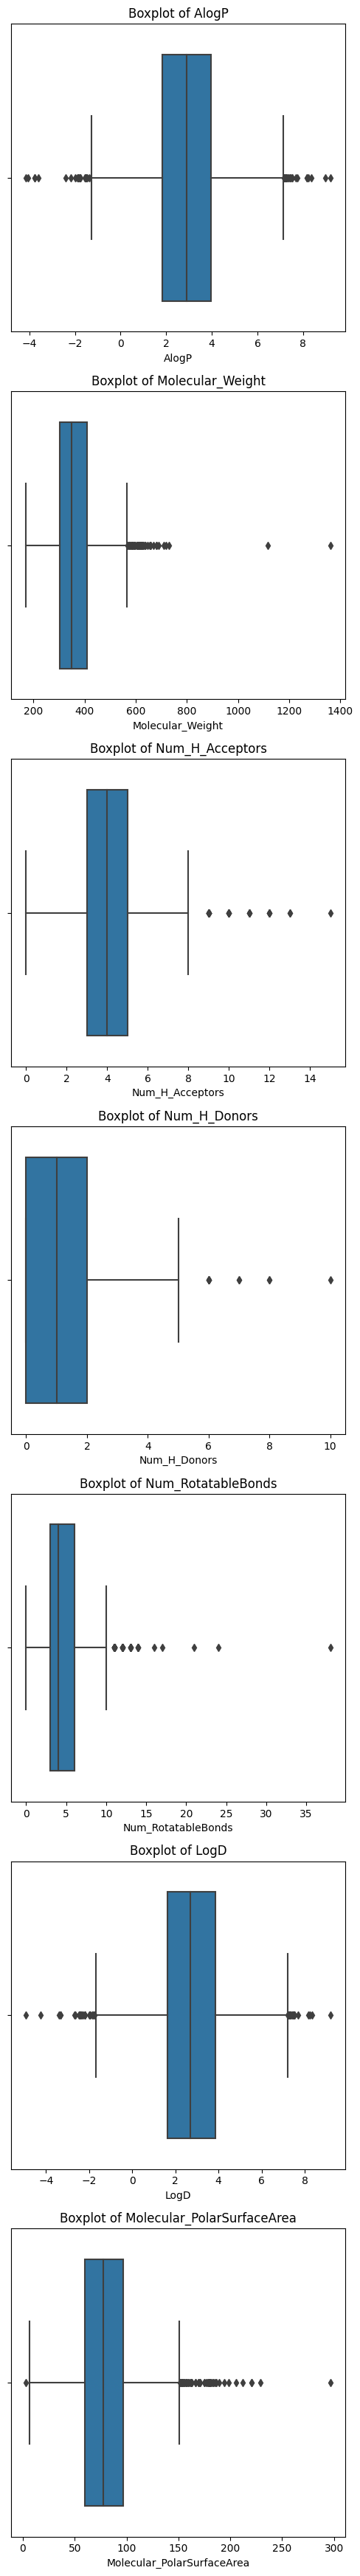

In [ ]:
# 수치형 데이터만 선택
numeric_columns = train_df.select_dtypes(include=['number']).columns



# MLM HLM 제외
feature_columns = numeric_columns.drop(['MLM', 'HLM'])


# boxplot - 아웃라이어
plt.figure(figsize=(5, len(feature_columns) * 5))

for i, column in enumerate(feature_columns, 1):
    plt.subplot(len(feature_columns), 1, i)
    sns.boxplot(x=train_df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

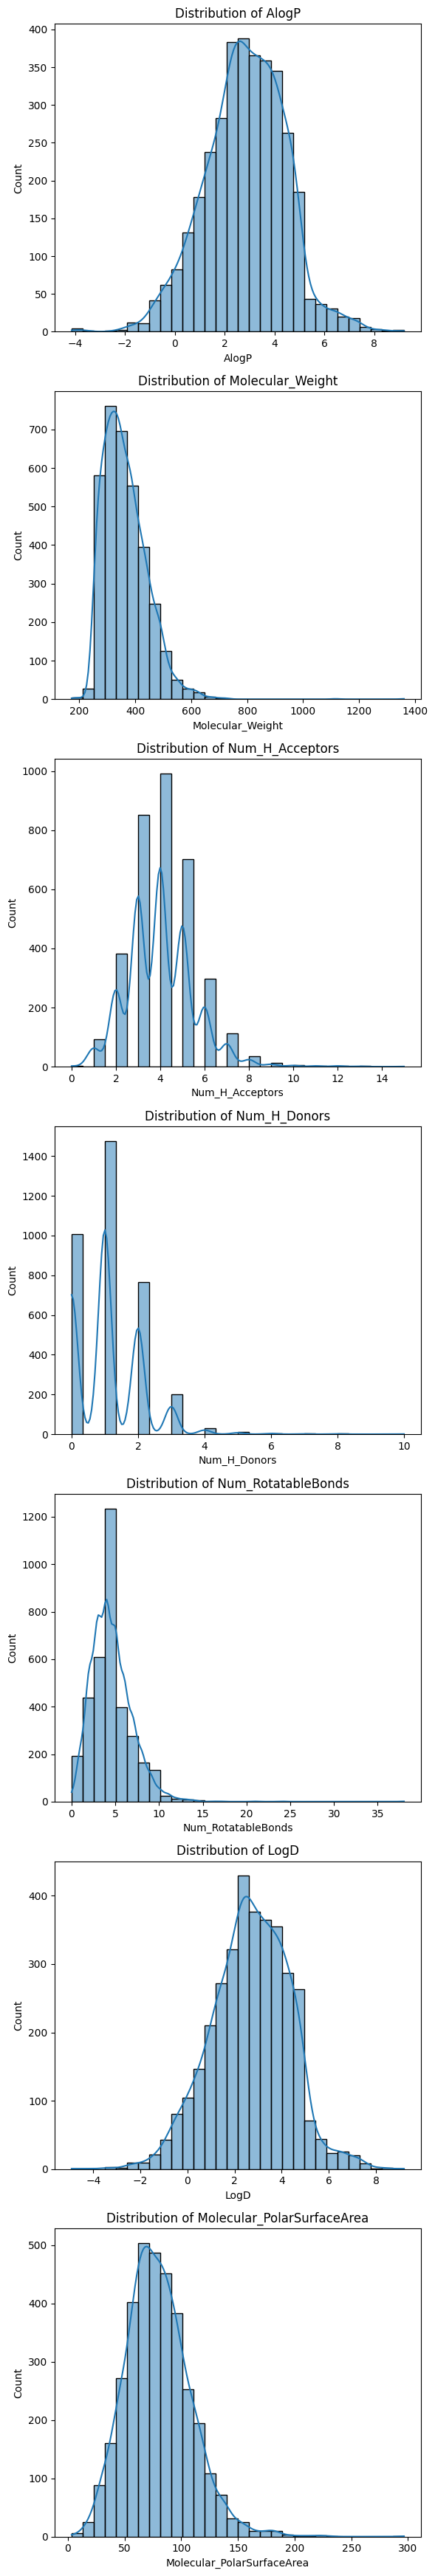

In [ ]:
# Plot the distribution of each numerical column - 정규분포
plt.figure(figsize=(6, len(feature_columns) * 5))
for i, column in enumerate(feature_columns, 1):
    plt.subplot(len(feature_columns), 1, i)
    sns.histplot(train_df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()


In [ ]:
from scipy import stats
import scipy.stats


# Z-Score 기반 이상치 제거
def remove_outliers_by_zscore(df, columns):
    df_cleaned = df.copy()
    for column in columns:
        z_scores = np.abs(stats.zscore(df_cleaned[column].dropna()))
        z_filter = (z_scores < 3)
        df_cleaned = df_cleaned[df_cleaned[column].index.isin(df_cleaned[column].dropna().index[z_filter])]
    return df_cleaned

# IQR 기반 이상치 제거
def remove_outliers_by_iqr(df, columns):
    df_cleaned = df.copy()
    for column in columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        df_cleaned = df_cleaned[~((df_cleaned[column] < (Q1 - 1.5 * IQR)) | (df_cleaned[column] > (Q3 + 1.5 * IQR)))]
    return df_cleaned

# 두 방법을 조합하여 이상치 제거
def remove_outliers(df, z_score_columns, iqr_columns):
    df_cleaned = df.copy()
    df_cleaned = remove_outliers_by_zscore(df_cleaned, z_score_columns)
    df_cleaned = remove_outliers_by_iqr(df_cleaned, iqr_columns)
    return df_cleaned



In [ ]:
# 'MLM'과 'HLM' 열을 제외한 열만 선택하여 새로운 DataFrame을 생성합니다.
feature_columns_df = train_df[feature_columns]

# 처음 5행을 출력
feature_columns_df.head()


,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,3.259,400.495,5,2,8,3.259,117.37
1,2.169,301.407,2,1,2,2.172,73.47
2,1.593,297.358,5,0,3,1.585,62.45
3,4.771,494.652,6,0,5,3.475,92.60
4,2.335,268.310,3,0,1,2.337,42.43


In [ ]:
z_score_columns = ['AlogP', 'LogD']

iqr_columns = ['Molecular_Weight', 'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'Molecular_PolarSurfaceArea']

# Remove outliers from train_df
train_df_cleaned = remove_outliers(feature_columns_df, z_score_columns, iqr_columns)
train_df.shape, train_df_cleaned.shape


((3498, 11), (3347, 7))

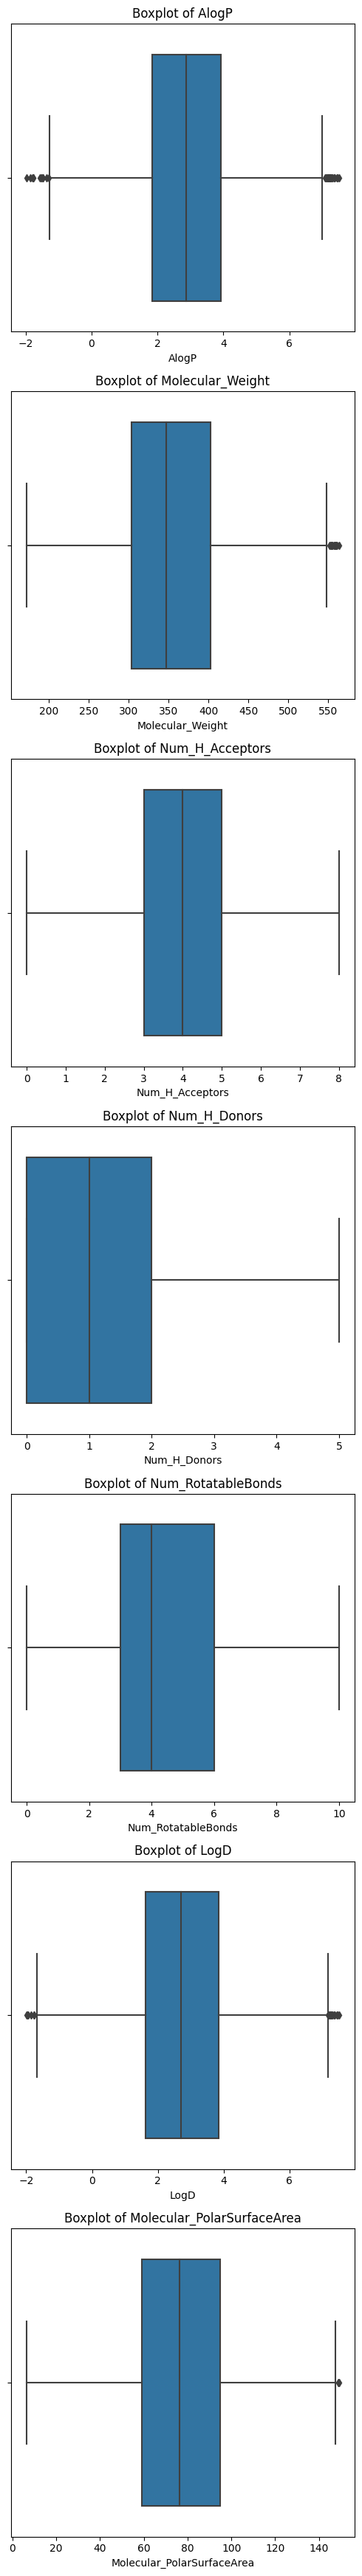

In [ ]:

# boxplot - 아웃라이어
plt.figure(figsize=(5, len(feature_columns) * 5))

for i, column in enumerate(feature_columns, 1):
    plt.subplot(len(feature_columns), 1, i)
    sns.boxplot(x=train_df_cleaned[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

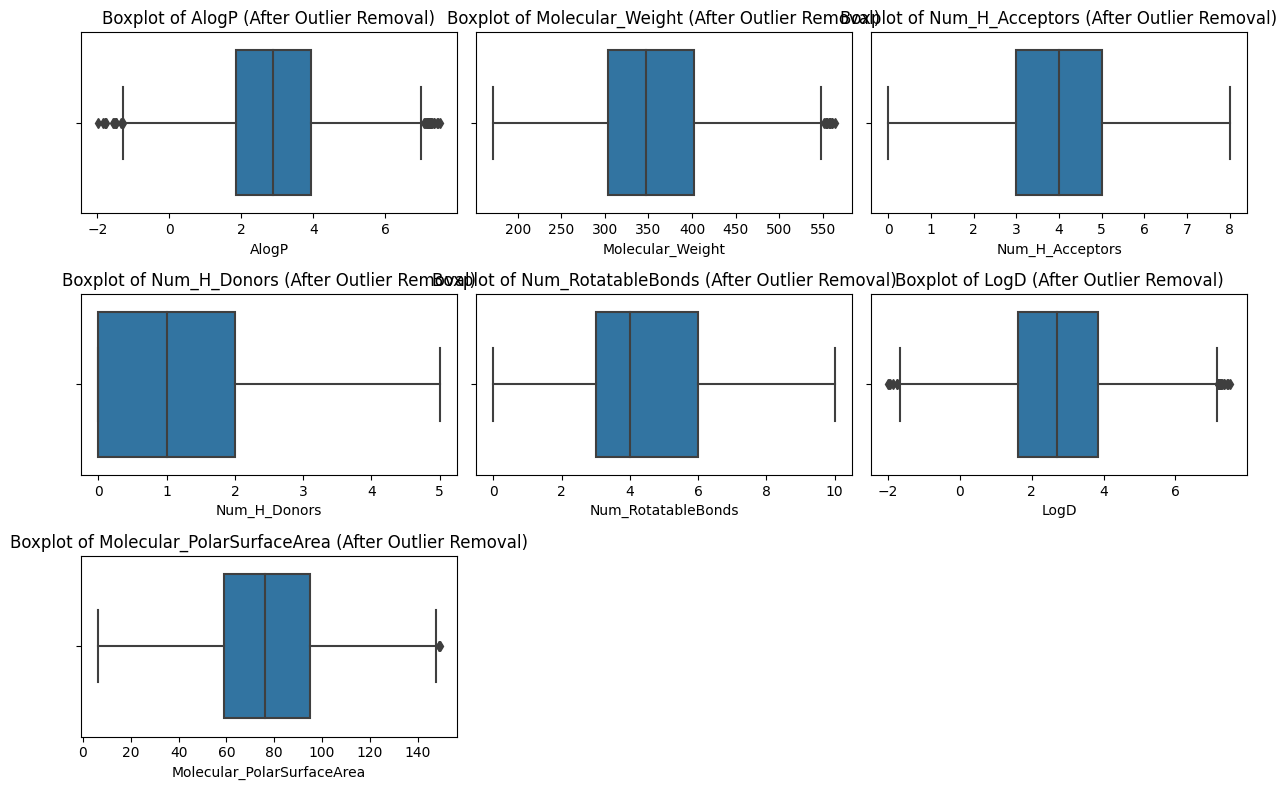

In [ ]:
# 이상치 제거 후의 Boxplot을 그립니다.
plt.figure(figsize=(12, 8))

# Boxplot 그리기
for i, column in enumerate(feature_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_df_cleaned[column])
    plt.title(f'Boxplot of {column} (After Outlier Removal)')

plt.tight_layout()
plt.show()


In [ ]:
# 이상치의 개수를 세는 함수를 정의합니다.
def count_outliers(df, columns):
    outlier_counts = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        outlier_counts[column] = outliers.shape[0]
    return outlier_counts

# 이상치의 개수
outlier_counts_after_removal = count_outliers(train_df_cleaned, feature_columns)
outlier_counts_after_removal


{'AlogP': 32,
 'Molecular_Weight': 14,
 'Num_H_Acceptors': 0,
 'Num_H_Donors': 0,
 'Num_RotatableBonds': 0,
 'LogD': 21,
 'Molecular_PolarSurfaceArea': 3}

In [ ]:
iqr_columns = ['AlogP', 'LogD']

z_score_columns = ['Molecular_Weight', 'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'Molecular_PolarSurfaceArea']

train_df_cleaned2 = remove_outliers(feature_columns_df, z_score_columns, iqr_columns)
train_df_cleaned.shape, train_df_cleaned2.shape

((3347, 7), (3326, 7))

In [ ]:
outlier_counts_after_removal = count_outliers(train_df_cleaned2, feature_columns)
outlier_counts_after_removal


# 이방법 x


{'AlogP': 2,
 'Molecular_Weight': 28,
 'Num_H_Acceptors': 0,
 'Num_H_Donors': 0,
 'Num_RotatableBonds': 0,
 'LogD': 1,
 'Molecular_PolarSurfaceArea': 24}

In [ ]:
# NaN 값을 각 열의 평균값으로 대체합니다.
train_df_cleaned = train_df_cleaned.fillna(train_df_cleaned.mean())

In [ ]:
from sklearn.ensemble import IsolationForest


# Isolation Forest 알고리즘을 초기화합니다.
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# 모델을 훈련 데이터에 적합시킵니다.
iso_forest.fit(train_df_cleaned)

# 이상치 예측: 1은 정상적인 데이터, -1은 이상치입니다.
outlier_predictions = iso_forest.predict(train_df_cleaned)

# 이상치가 아닌 데이터만 선택합니다.
train_df_isolation_forest = train_df_cleaned[outlier_predictions == 1]

# 결과를 확인합니다: 처음 5개의 행과 데이터프레임의 크기
train_df_isolation_forest.head(), train_df_isolation_forest.shape



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(   AlogP  Molecular_Weight  Num_H_Acceptors  Num_H_Donors  Num_RotatableBonds  \
 0  3.259           400.495                5             2                   8   
 1  2.169           301.407                2             1                   2   
 2  1.593           297.358                5             0                   3   
 3  4.771           494.652                6             0                   5   
 4  2.335           268.310                3             0                   1   
 
     LogD  Molecular_PolarSurfaceArea  
 0  3.259                      117.37  
 1  2.172                       73.47  
 2  1.585                       62.45  
 3  3.475                       92.60  
 4  2.337                       42.43  ,
 (3179, 7),
 (3347, 7))

In [ ]:
outlier_counts_after_removal = count_outliers(train_df_isolation_forest, feature_columns)
outlier_counts_after_removal


{'AlogP': 13,
 'Molecular_Weight': 14,
 'Num_H_Acceptors': 0,
 'Num_H_Donors': 0,
 'Num_RotatableBonds': 0,
 'LogD': 8,
 'Molecular_PolarSurfaceArea': 5}

In [ ]:
# 남아 있는 이상치를 추가로 IQR 방법을 사용하여 제거합니다.
train_df_further_cleaned = remove_outliers_by_iqr(train_df_isolation_forest, feature_columns)

# 결과를 확인합니다: 처음 5개의 행과 데이터프레임의 크기
print(train_df_further_cleaned.head(), train_df_further_cleaned.shape)

# 마지막 이상치 개수 확인
outlier_counts_after_further_removal = count_outliers(train_df_further_cleaned, feature_columns)
outlier_counts_after_further_removal



   AlogP  Molecular_Weight  Num_H_Acceptors  Num_H_Donors  Num_RotatableBonds  \
0  3.259           400.495                5             2                   8   
1  2.169           301.407                2             1                   2   
2  1.593           297.358                5             0                   3   
3  4.771           494.652                6             0                   5   
4  2.335           268.310                3             0                   1   

    LogD  Molecular_PolarSurfaceArea  
0  3.259                      117.37  
1  2.172                       73.47  
2  1.585                       62.45  
3  3.475                       92.60  
4  2.337                       42.43   (3143, 7)


{'AlogP': 0,
 'Molecular_Weight': 2,
 'Num_H_Acceptors': 0,
 'Num_H_Donors': 0,
 'Num_RotatableBonds': 0,
 'LogD': 1,
 'Molecular_PolarSurfaceArea': 0}

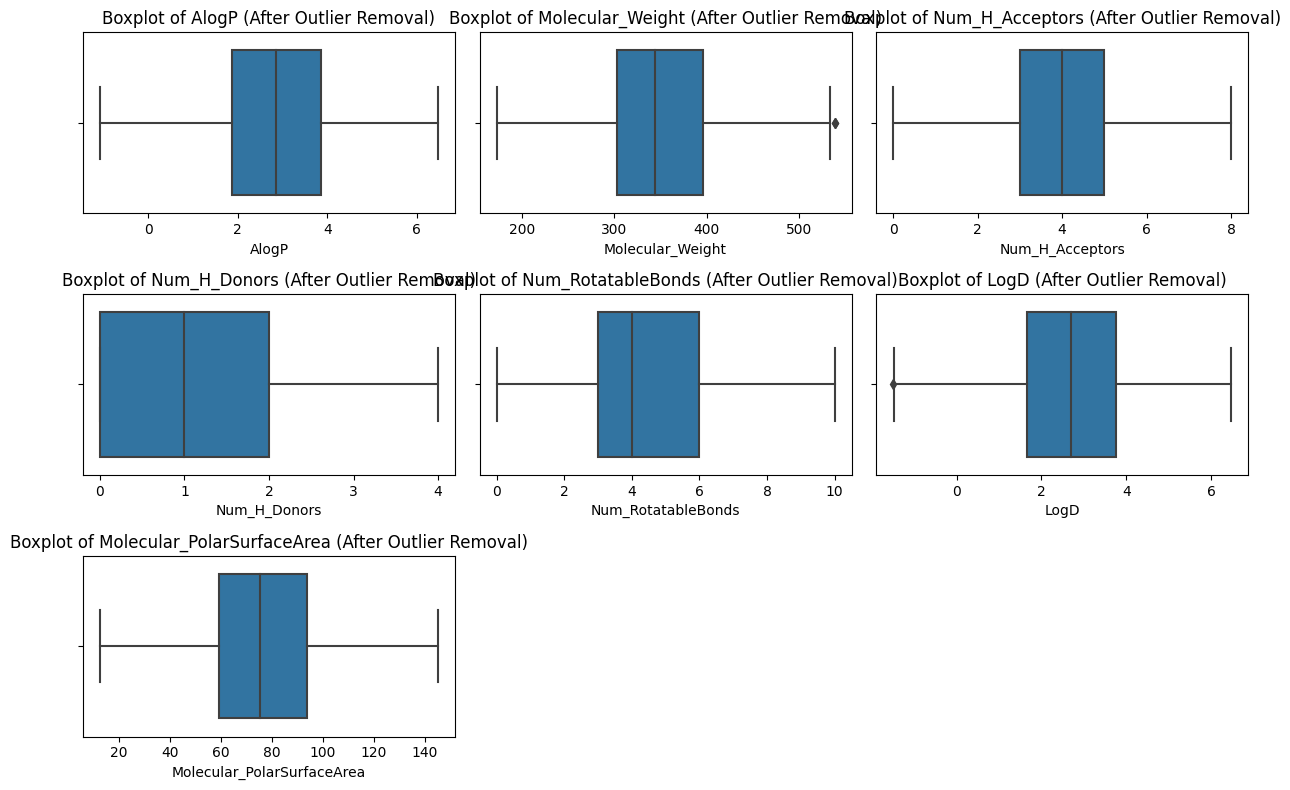

In [ ]:
# 이상치 제거 후의 Boxplot을 그립니다.
plt.figure(figsize=(12, 8))

# Boxplot 그리기
for i, column in enumerate(feature_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_df_further_cleaned[column])
    plt.title(f'Boxplot of {column} (After Outlier Removal)')

plt.tight_layout()
plt.show()

# 정규화

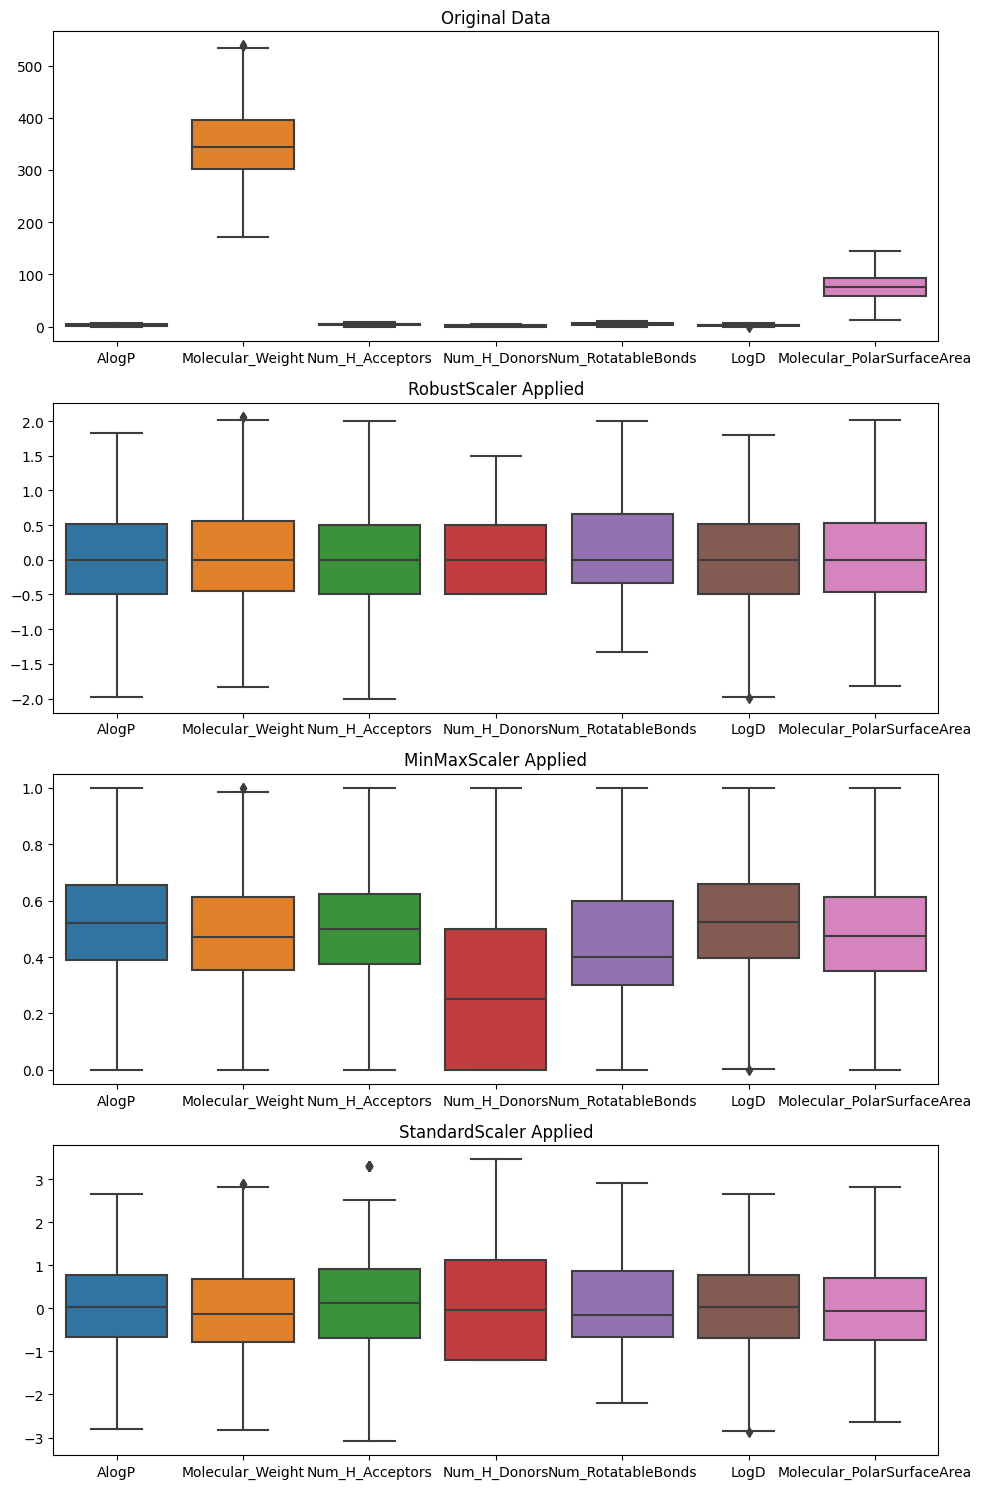

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler,StandardScaler

# 각종 스케일러 초기화
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# 데이터 스케일링
train_df_robust_scaled = robust_scaler.fit_transform(train_df_further_cleaned)
train_df_minmax_scaled = minmax_scaler.fit_transform(train_df_further_cleaned)
train_df_standard_scaled = standard_scaler.fit_transform(train_df_further_cleaned)


# 스케일링된 데이터를 DataFrame으로 변환
train_df_robust_scaled = pd.DataFrame(train_df_robust_scaled, columns=feature_columns)
train_df_minmax_scaled = pd.DataFrame(train_df_minmax_scaled, columns=feature_columns)
train_df_standard_scaled = pd.DataFrame(train_df_standard_scaled, columns=feature_columns)

# 데이터 분포를 시각적으로 비교
fig, axes = plt.subplots(4, 1, figsize=(10, 15))

# 원본 데이터
sns.boxplot(data=train_df_further_cleaned, ax=axes[0])
axes[0].set_title('Original Data')

# RobustScaler 적용 데이터
sns.boxplot(data=train_df_robust_scaled, ax=axes[1])
axes[1].set_title('RobustScaler Applied')

# MinMaxScaler 적용 데이터
sns.boxplot(data=train_df_minmax_scaled, ax=axes[2])
axes[2].set_title('MinMaxScaler Applied')

# StandardScaler 적용 데이터
sns.boxplot(data=train_df_standard_scaled, ax=axes[3])
axes[3].set_title('StandardScaler Applied')


plt.tight_layout()
plt.show()


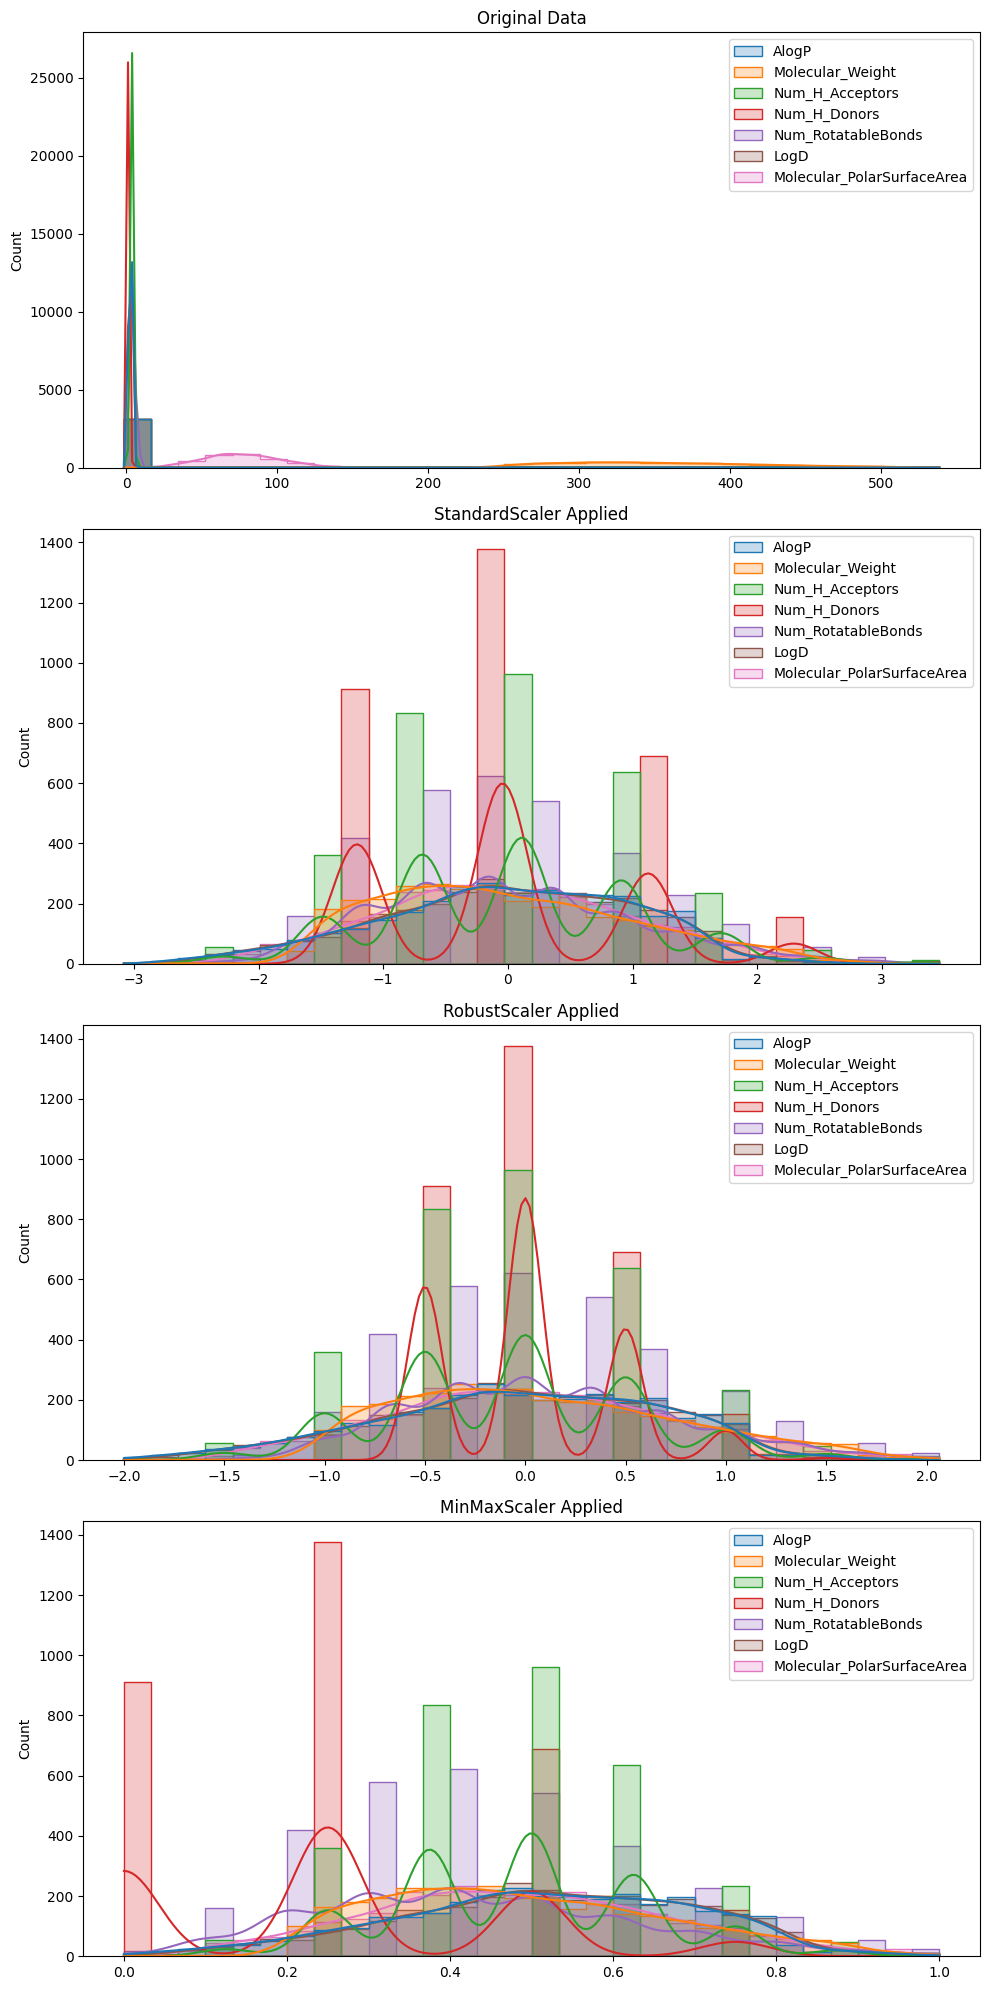

In [ ]:
# 각 스케일러에 대한 데이터 분포를 히스토그램으로 시각화
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# 원본 데이터
sns.histplot(train_df_further_cleaned, bins=30, kde=True, ax=axes[0], element="step")
axes[0].set_title('Original Data')

# StandardScaler 적용 데이터
sns.histplot(train_df_standard_scaled, bins=30, kde=True, ax=axes[1], element="step")
axes[1].set_title('StandardScaler Applied')

# RobustScaler 적용 데이터
sns.histplot(train_df_robust_scaled, bins=30, kde=True, ax=axes[2], element="step")
axes[2].set_title('RobustScaler Applied')

# MinMaxScaler 적용 데이터
sns.histplot(train_df_minmax_scaled, bins=30, kde=True, ax=axes[3], element="step")
axes[3].set_title('MinMaxScaler Applied')

plt.tight_layout()
plt.show()
